____

**project**: `Melanoma Type Detection`

**date**: `2023-07-02`

**decription**: `given an image of a melanoma skin cancer the model should accurately predict the type of melonoma cancer on that image between (benign and malignant)`.

**main**: `computer vision(cv) pytorch`

**architecture**:  `VGG_19`

**language**: `python`
____

### Problem Statement

> `Melanoma` is a type of cancer that can be deadly if not detected early. It accounts for `75%` of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### MELONOMA SKIN CANCER DETECTION

In this notebook I will train a computer vision model using deep learning techniques to classify the type of makenoma skin cancer based on the dataset that was obtained on [kaggle/melanoma-skin-cancer-dataset-of-10000-images](https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images). So our goal is to create a model that does a binary classification on the type of `melanoma` between the following:

1. `benign`
2. `malignant`

![alt](https://molemap.s3.amazonaws.com/images/images/Skin-cancer-types_9.5_2023-02-23-035010_lrny.jpg)


### Data
In this notebook we will train a simple image classification model that does abinary classification based on the dataset that was obtained from [kaggle](https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images). So our goal in this notebook is to create a model using `Deep Neural Networks` that accurately predicts two types of melanoma which are `benign` & `malignant`.

### Model Architecture

In this notebook we will create a image clasifier model that will classify `2` diffent types of melonoma. So basically this is a binary classification problem which will be able to predict if the given image of melonoma skin cancer is  `malignant` or `benign`. We will use the [`VGG`](https://arxiv.org/abs/1409.1556) achitecture. VGG is a neural network model that uses convolutional neural network (`CNN`) layers and was designed for the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/), which it won in `2014`.

![img](https://camo.githubusercontent.com/4a95524c0608be70ea00ca0ab5c92964511f4d55d8ce2f96235c9607936b1755/68747470733a2f2f6769746875622e636f6d2f62656e747265766574742f7079746f7263682d696d6167652d636c617373696669636174696f6e2f626c6f622f6d61737465722f6173736574732f7667672d7461626c652e706e673f7261773d31)

The commonly used `VGG` variants are `VGG11`, `VGG13` and `VGG19`, which correspond to configurations `"A"`, `"B"`, and `"E"`. Configurations `"A-LRN"` and `"C"` - which is the same as `"D"` but with smaller filter sizes in some convolutional layers - which are rarely used.

This notebook we are going to focus on the `E` configuration of `VGG` which is called `VGG19`. We are not going to train our model from scratch we are going to use a well known strategy in deep learning called `transfare-learning` the `VGG19` achitecture looks as follows:

![alt](https://viso.ai/wp-content/uploads/2021/10/vgg-neural-network-architecture.png)


### Transfare Leaning

The act of using a pre-trained model is generally known as transfer learning, as we are learning to transfer knowledge from one task to another. It is also referred to as fine-tuning, as we fine-tune our parameters trained on one task to the new, downstream task. The terms transfer learning and fine-tuning are used interchangably in machine learning.

This means we don't have to learn them from scratch when using the pre-trained model for our task, causing our model to converge earlier. We can also think of the pre-trained model as being a very good set of weights to initialize our model from, and using pre-trained models usually leads to a performance improvement compared to initializing our weights randomly.

Usually we will initialize our weights randomly - following some weight initialization scheme - and then train our model. Using a pre-trained model means some - potentially all - of our model's weights are not initialized randomly, but instead taken from a copy of our model that has already been trained on some task. The task the model has been pre-trained on does not necessarily have to match the "downstream task" - the task we want to use the pre-trained model on. For example, a model that has been trained to classify images can then be used to detect objects within an image.



### Installing Helper Packages

In the following code cell we are going to install the package called `helperfns` that provide us with some usefull helper functions for machine learning.

We are also going to install `kaggle` which will allow us to interact with kaggle datasets, so that we can download the dataset that we want from kaggle.


In [115]:
!pip install helperfns==0.0.6 kaggle -q

### Imports
In the following code cell we are going to import all the packages that we are going to use throughout this notebook.

In [117]:
import torch
import random
import os
import time
import torchvision
import copy

import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils import data
from PIL import Image
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score
from sklearn import decomposition, manifold
from helperfns.tables import tabulate_data
from helperfns.visualization import plot_complicated_confusion_matrix, plot_simple_confusion_matrix
from helperfns.torch import models
from helperfns.utils import hms_string

from helperfns import visualization


from torch.optim.lr_scheduler import _LRScheduler
from tqdm.notebook import tqdm
import seaborn as sns
import pathlib
import matplotlib as mpl

torch.__version__

'2.0.1+cu118'

### Seed
In the following code cell we are going to set-up the `SEED` for reproducivity in this notebook.

In [ ]:
SEED = 23

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Device
In the following code cell we are going to get the `gpu` as our device if possible for training speed.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data

As we mentioned the dataset that we are going to use is from `kaggle` we need a way of downloading and extracting it from `kaggle`. We will follow the steps that we listed on one of my previous notebooks [05_ResNet.ipynb](https://github.com/CrispenGari/pytorch-python/blob/main/03_Torch_Vision/03_Image_Classification/05_ResNet.ipynb).

In [ ]:
os.environ["KAGGLE_USERNAME"]= "YOUR_USERNAME"
os.environ['KAGGLE_KEY'] = "YOUR_KAGGLE_KEY"

In [ ]:
!kaggle datasets download hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images --unzip

 98% 97.0M/98.7M [00:05<00:00, 24.1MB/s]
100% 98.7M/98.7M [00:05<00:00, 19.2MB/s]


To handle our dataset we are going to use the torch-vision class called `dataset.ImageFolder` and it expect the folder structure looks as follows:

```
📂set (train|test|validatio)
 📂 classx
    🖼 x.png
    🖼 x.jpg
  ....

 📂 classy
    🖼 x.png
    🖼 x.jpg
    ...

*** KEY
🖼 x.png - is an image that belongs to class x.

```
This is exactly how our images are grouped in the `melanoma_cancer_dataset` folder. Our dataset only have two sets which is:

1. `train`
2. `test`


We are going to take a fraction from the train data to come up with our validation data. Then during data argumentation we use the test transforms on our validation data.

First let's define our base path to the images.

In [ ]:
base_path = 'melanoma_cancer_dataset'

### Data Argumentation

Neural networks are extremely data-hungry, and training them requires many training examples. It is, of course, only sometimes possible to have a large amount of training data. We can use Data Augmentation to expand the number of available examples artificially. Data Augmentation is the process of tweaking the given examples multiple times in different ways to generate new training samples from the existing images. Some examples of Data Augmentation for image data include Random Flipping, Jittering Brightness/Contrast, Random Resizing, and Random Cropping.


![img](https://github.com/CrispenGari/cv-torch/blob/main/05_CANCER_AI_VGG19/images/augmentation.png?raw=true)

> Data augmentation is a good method for improving image classification accuracy. The idea behind this technique is that a `dog` remains a dog even in the dark, when it is looking upside down & even when it is small.


### Image Transformations

We are going to be using a pre-trained model we will need to ensure that our images are the same size and have the same normalization as those used to train the model - which we find on the torchvision [models](https://nbviewer.jupyter.org/github/bentrevett/pytorch-image-classification/blob/master/5_resnet.ipynb) page.


For data argumentation we are going to apply the following data argumentations in our `train` dataset:

1. `Resize(pretrained_size)`
2. `RandomRotation(5)`
3. `RandomHorizontalFlip(0.5)`
4. `RandomCrop(pretrained_size` padding = 10)`
5. `ToTensor()`
6. `Normalize(mean = pretrained_means, std = pretrained_stds)`


And we are going to apply the following data argumentations in our `test` and `validation` sets.


1. `Resize(pretrained_size)`
2. `ToTensor()`
3. `Normalize(mean = pretrained_means, std = pretrained_stds)`


> Note that the validation and the test transforms are the same.

In [ ]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

image_transforms = {
    "train": transforms.Compose([
            transforms.Resize(pretrained_size),
            transforms.RandomRotation(5),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomCrop(pretrained_size, padding = 10),
            transforms.ToTensor(),
            transforms.Normalize(mean = pretrained_means,
                                std = pretrained_stds)
          ]),
    "valid": transforms.Compose([
          transforms.Resize(pretrained_size),
          transforms.ToTensor(),
          transforms.Normalize(mean = pretrained_means,
                            std = pretrained_stds)
        ]),
    "test": transforms.Compose([
          transforms.Resize(pretrained_size),
          transforms.ToTensor(),
          transforms.Normalize(mean = pretrained_means,
                            std = pretrained_stds)
    ])
}

### Loading our custom Data

Next we are going to create an image_dataset using the `datasets.ImageFolder` from `torchvision` for  train and test sets.

In [ ]:
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(base_path, x),
        transform = image_transforms[x]
    ) for x in os.listdir(base_path)
}

Let's get the class names in our dataset.

In [ ]:
class_names = image_datasets["train"].classes
class_names

['benign', 'malignant']

We can also get classes to index which shows us the classname pared to the integer representation of that class.

In [ ]:
image_datasets['train'].class_to_idx

{'benign': 0, 'malignant': 1}

Now we can create a validation data from the train set.

> Note that the validation data will come from the `train` set. We are going to take a ratio of `10%` and give it to the validation set and then the rest will remain in the train data.

In [ ]:
train_data = image_datasets["train"]
test_data = image_datasets["test"]

VALID_RATIO = 0.9
n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

Overiding the transforms of the train on the validation set with the validation transforms that we have defined previously.

In [ ]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = image_transforms['valid']

### Checking examples
In the following code cell we are going to count how many examples we are having from our dataset.

In [ ]:
title = "DATASETS EXAMPLES"
columns = "SET", "TOTAL"
data_rows = [("training", len(train_data)),
             ("testing", len(test_data)),
             ("validation", len(valid_data)),
             ("total", f"{len(valid_data) + len(test_data) + len(train_data):,}")
]
tabulate_data(columns, data_rows, title)

DATASETS EXAMPLES
+------------+--------+
| SET        |  TOTAL |
+------------+--------+
| training   |   8644 |
| testing    |   1000 |
| validation |    961 |
| total      | 10,605 |
+------------+--------+


The following pie chat shows the distribution of examples in each set.

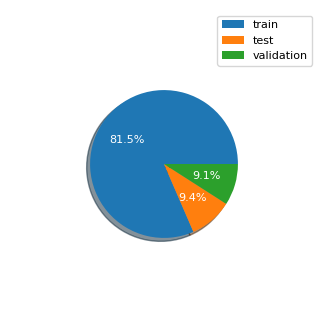

In [ ]:
plt.figure(figsize=(4, 4))
plt.pie([len(train_data), len(test_data), len(valid_data)], explode= [.0, .0, .0], labels=['train', 'test', 'validation'],
        pctdistance=0.6, shadow=True, autopct='%1.1f%%', textprops={'color': 'white', 'fontsize':8}, radius=.6)
plt.legend(fontsize=8)
plt.show()

### Iterator
In the following code cell we are then going to create an `iterator` with the batchsize of `128`

In [ ]:
BATCH_SIZE = 128

train_iterator = data.DataLoader(
    train_data, shuffle=True, batch_size= BATCH_SIZE
)
valid_iterator = data.DataLoader(
    valid_data, batch_size= BATCH_SIZE
)
test_iterator = data.DataLoader(
    test_data,  batch_size= BATCH_SIZE
)

### Visualizing Images
Now we can go ahead and visualize the images that we are having in this dataset.

In [ ]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

In the following code cell we are going to define the `melanoma_types`  as a lists for later usage.

In [ ]:
melanoma_types = [
    { "id": id,  "type": _type }
    for _type, id in image_datasets['train'].class_to_idx.items()
]

In the following code cell we are going to define a function that will plot the normalised images from our datasets.

In [ ]:
def plot_images(images, labels, classes, normalize = True):
  n_images = len(images)
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize = (10, 10))
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image = images[i]
    if normalize:
        image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(melanoma_types[labels[i]]["type"], fontsize=10)
    ax.axis('off')

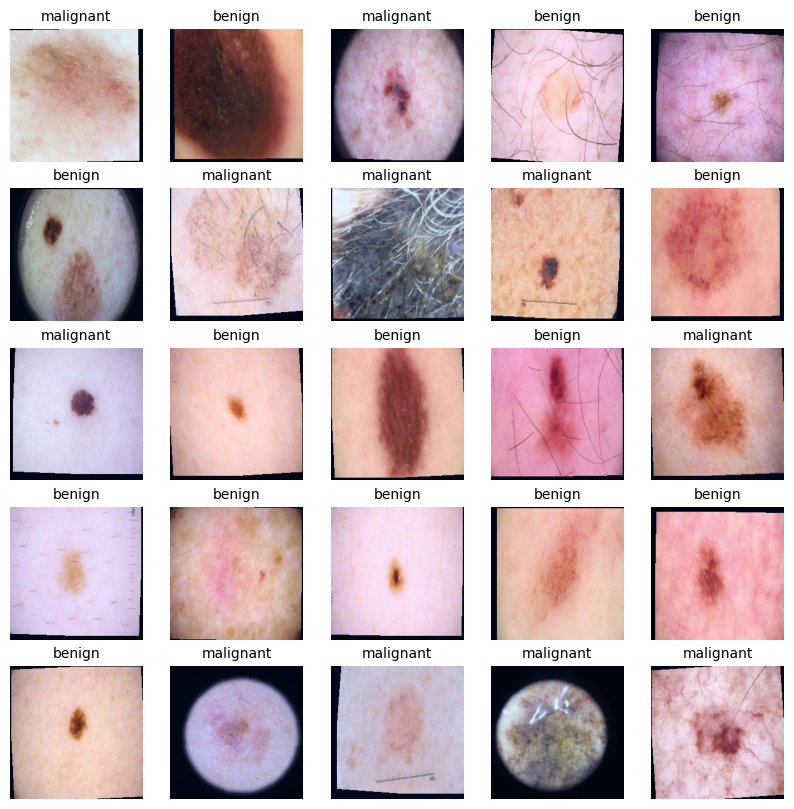

In [119]:
N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in
                           [train_data[i] for i in range(N_IMAGES)]])
classes = test_data.classes
plot_images(images, labels, classes)

### Defining Model
As we said we will use the `VGG_19` model based on [this notebook](https://github.com/CrispenGari/pytorch-python/blob/main/03_Torch_Vision/03_Image_Classification/04_VGG.ipynb)
we are going to define our model achitecture in the code cells that follows.

Let's start by defining the `VGG` architecture in the following code cell:



In [ ]:
class VGG(nn.Module):
  def __init__(self, features, output_dim):
    super(VGG, self).__init__()
    self.features = features
    self.avgpool = nn.AdaptiveAvgPool2d(7)

    self.classifier = nn.Sequential(
      nn.Linear(512 * 7 * 7, 4096),
      nn.ReLU(inplace = True),
      nn.Dropout(0.5),
      nn.Linear(4096, 4096),
      nn.ReLU(inplace = True),
      nn.Dropout(0.5),
      nn.Linear(4096, output_dim)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    h = x.view(x.shape[0], -1)
    x = self.classifier(h)
    return x, h

### Improving Model Accuracy
The two biggest hurdles in training neural networks are `Overfitting` and Underfitting. In the first case, the network memorizes the data; in the second, the network needs to learn more. The following techniques can be divided into categories based on these two concepts. `Dropout layers`, `Data augmentation`, `Regularization`, `Early Stopping`, tackle Overfitting. `Transfer Learning` and `Hyperparameter` Tuning tackles `Underfitting`. If there is a lack of data, we can use `Transfer learning` and `Data Augmentation`. In our case we are using Data argumentation together with transfare learning to improve our model.

### What is Overfitting and Underfitting?

It is important to remember that `Overfitting` and `Underfitting` are not binary states but a continuum. It is a balance between memorizing the training data and generalizing to unseen data, and finding the right balance can be difficult and require experimentation. In addition to `Overfitting` and `Underfitting`, we should monitor other metrics such as accuracy, precision, recall, and loss during training. These challenges make training a neural network a balancing act.

* `Underfitting` occurs when the model focuses too heavily on the training data and fails to predict any sample it has yet to see.
If the training accuracy is very low and the validation accuracy seems to fluctuate or is much higher than the training accuracy, this is called `Underfitting`. In `Underfitting`, the model must be more powerful to fit the data.
* Both `Overfitting` and `Underfitting` can be countered in many ways, but it is to be noted that they have a delicate balance. Understanding which of these the network is going through is essential in improving image classification accuracy.



![img](https://github.com/CrispenGari/cv-torch/blob/main/05_CANCER_AI_VGG19/images/overfitting-underfitting.png?raw=true)


### What techiques did we use to address the issue of overfiting since underfitting can be addressed using transfare leaning?

1. `Dropout Layers` -
When the single unit in a network computes gradients wrt the error, it also considers the other units and tries to fix their mistakes. This dependency is known as Co Adaptation and leads to the formation of complex relations that encourages `Overfitting`. Dropout layers reduce co-dependence between the neurons in a network by randomly (with a probability p) setting neuron activations to 0. This layer is applied to Dense (Fully connected) layers in a network. `Dropout` helps with smaller datasets and slightly with larger ones. If the dataset is bigger, `Dropout` can help performance as more information is recovered. Similarly, if the dataset is too large, the model performance might also worsen. During testing, the weights are scaled by the probability `p`.


![img](https://github.com/CrispenGari/cv-torch/blob/main/05_CANCER_AI_VGG19/images/dropout.png?raw=true)

> We can see that we are having dropout layers in our `VGG` achitecture.



### `VGG_19` configuration
The `"E"` configuration which is also known as the `vgg19_config` is typically the VGG configurations are defined as lists. Each item in the list is either 'M', which denotes a max pooling layer, or an integer, which denotes a convolutional layer with that many filters.

In the following code cell we are going to define the `E` config.

In [ ]:
E = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',
                512, 512, 512, 512, 'M']

We can now define a function which takes in a configuration list and returns a `nn.Sequential` with the respective layers.

In [ ]:
def get_vgg_layers(config, batch_norm):
  layers = []
  in_channels = 3
  for c in config:
    assert c == 'M' or isinstance(c, int)
    if c == 'M':
      layers += [nn.MaxPool2d(kernel_size = 2)]
    else:
      conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
      if batch_norm:
          layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
      else:
          layers += [conv2d, nn.ReLU(inplace = True)]
      in_channels = c
  return nn.Sequential(*layers)

Now, let's get the features for the `VGG19` architecture, with batch normalization.

In [ ]:
vgg19_layers = get_vgg_layers(E, batch_norm = True)
print(vgg19_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

We can then pass these features to our base VGG module to get our `VGG19` model.

> Note that the output dimension is `1` in this case since this is a binary classification task.

In [ ]:
OUTPUT_DIM = 1
mtscd_model = VGG(vgg19_layers, OUTPUT_DIM).to(device)
mtscd_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### Counting model Parameters
In the following code cell we are going to count the `model` parameters of our model.

In [ ]:
models.model_params(mtscd_model)

TOTAL MODEL PARAMETERS: 	139,585,345
TOTAL TRAINABLE PARAMETERS: 	139,585,345


### Pretrained Models.

In this notebook I'm  actually not going to use a VGG model with parameters that have been randomly initialized VGG model. I'm going to be using a VGG model with pre-trained parameters. Using a pre-trained model involves initializing our model with parameters that have already been trained for a certain task - usually not the exact same task we are trying to do ourselves.

In [ ]:
pretrained_model = torchvision.models.vgg19_bn(pretrained = True)
pretrained_model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:07<00:00, 81.7MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

We can count the pretrained model parameters as follows:


In [ ]:
models.model_params(pretrained_model)

TOTAL MODEL PARAMETERS: 	143,678,248
TOTAL TRAINABLE PARAMETERS: 	143,678,248


### Fine Tuning Technique

Our pretrained `VGG_19` model has `1000` output features of which we only have `2` classes in our dataset. We want to modify the last layer of our pretrained model so that it will have the output size based on our classes which is `1`. We are saying 1 ofwhich we have `2` classes because this is a binary classification task.



![img](https://github.com/CrispenGari/cv-torch/blob/main/05_CANCER_AI_VGG19/images/transfer-learning1.png?raw=true)

Since most vision datasets have some common features, it is possible to take a network trained on a similar dataset and use the trained features to reduce training time on a different dataset. Transfer learning is a procedure that lets a pre-trained model be used either as a feature extractor or as a weight initializer. In most cases, Transfer learning is used for fine-tuning. We can transfer knowledge from a network trained on a complex task to a simpler one or from a network trained on large amounts of data to one with fewer data. Transfer learning is thus a potential key to multi-task learning, an active field of research in deep learning. This technique is also key in quickly improving image classification accuracy with fewer data. The following diagram shows the concept behind using Transfer learning to improve image classification `accuracy`.

In [ ]:
IN_FEATURES = pretrained_model.classifier[-1].in_features
final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
final_fc

Linear(in_features=4096, out_features=1, bias=True)

We can directly overwrite the previous linear layer with our new linear layer.

In [ ]:
pretrained_model.classifier[-1] = final_fc

We can then print out the classifier of our model to ensure the final linear layer now has an output dimension of `1`.

In [ ]:
print(pretrained_model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1, bias=True)
)


We could go ahead and use the `pretrained_model` module from here on out, however it only returns the final output layer and not the intermediate representation as our model does. We can see that in the model's definition here.

We can load the parameters of the `pretrained_model` into our model by loading the parameters `(state_dict)` from the `pretrained_model` into our model in the same way we loaded the "best" saved parameters in some cases - by using `load_state_dict`. However, this time we load directly from the `pretrained_model` instead of using `torch.load` on the path of the saved model parameters.

This is only possible as our model has the exact same layers (order and shape) as the `pretrained_model` with the final linear layer replaced with our `1` dimensional output linear layer.

In [ ]:
mtscd_model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

Instead of training all of the parameters we have loaded from a pre-trained model, we could instead only learn some of them and leave some "frozen" at their pre-trained values. As our model will then have less trainable parameters it will usually train faster and we can usually fit it on smaller GPUs.

We can freeze the model trainable parameters of our model features using as follows:

```py
for parameter in model.features.parameters():
    parameter.requires_grad = False
```

We could also freeze the classifier layer, however we always want to train the last layer as this is what we have initialized randomly and needs to be trained. Freezing all but the last layer in the classifier can be done with:

```py
for parameter in model.classifier[:-1].parameters():
    parameter.requires_grad = False
```

In [ ]:
for parameter in mtscd_model.features.parameters():
    parameter.requires_grad = False

for parameter in mtscd_model.classifier[:-1].parameters():
    parameter.requires_grad = False

We can also count the model parameters after loading the pretrained weigths and freezing some layers as follows.

In [ ]:
models.model_params(mtscd_model)

TOTAL MODEL PARAMETERS: 	139,585,345
TOTAL TRAINABLE PARAMETERS: 	4,097


### Model Training
In the following code cell we are going to create create `optimizer` and `criterion`. Note that for the optimizer we are going to use the `Adam` with default parameters and `BCEWithLogitsLoss` as our loss function since it is a binary classification task.


> Note that this loss functions expect labels to be `float` we will change them to float during training and evaluation.



### The leaning rate finder.

> **Note:** the learning rate finder is more of an art than a science. It is not going to find an exact learning rate to 10 decimal places which will always give us `100%` accuracy - but it is usually going to be better than just picking a learning rate out of thin air.

The most commonly used optimizer used is Adam. Adam's default learning rate is usually a fine choice but, much like how we manually initialized our parameters to potentially get some performance improvement, we can try and calculate an optimal learning rate manually.

#### How does the learning rate finder work?

We give the finder our model, optimizer and criterion we want to use. However we give it an optimizer with a much lower learning rate than we are expecting to use. We then train the model on the batches of data from the training set - calculating the loss and updating the parameters. After each batch we increase the learning rate exponentially from the initial, extremely low learning rate to a learning rate we know will be too high. This repeats until our loss diverges (over 5x the best loss achieved) or we reach our defined maximum learning rate.

At each batch we are recording the learning rate and the loss achieved on that batch. By plotting them against each other we can find a suitable learning rate - but more on how to do that in a bit.

The losses calculated are usually quite noisy so we actually save the exponentially weighted average of the loss calculated.

We also want to use our initialized parameters, not the ones obtained by upgrading the parameters when performing the learning rate finder. Hence we save the model parameters to disk when initializing the finder and then they are reset to our desired initialized ones just before the range_test function returns by loading the initial values from disk.

## The `IteratorWrapper`

In [ ]:
class IteratorWrapper:
  def __init__(self, iterator):
    self.iterator = iterator
    self._iterator = iter(iterator)
  def __next__(self):
    try:
      inputs, labels = next(self._iterator)
    except StopIteration:
      self._iterator = iter(self.iterator)
      inputs, labels, *_ = next(self._iterator)
    return inputs, labels
  def get_batch(self):
      return next(self)

### The `ExponentialLR`

In [ ]:
class ExponentialLR(_LRScheduler):
  def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
    self.end_lr = end_lr
    self.num_iter = num_iter
    super(ExponentialLR, self).__init__(optimizer, last_epoch)

  def get_lr(self):
    curr_iter = self.last_epoch
    r = curr_iter / self.num_iter
    return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

### The `LRFinder`

In [ ]:
class LRFinder:
  def __init__(self, model, optimizer, criterion, device):
    self.optimizer = optimizer
    self.model = model
    self.criterion = criterion
    self.device = device
    torch.save(model.state_dict(), 'init_params.pt')

  def range_test(self, iterator, end_lr = 10, num_iter = 100,
                smooth_f = 0.05, diverge_th = 5):
    lrs = []
    losses = []
    best_loss = float('inf')
    lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
    iterator = IteratorWrapper(iterator)

    for iteration in range(num_iter):
      loss = self._train_batch(iterator)
      lrs.append(lr_scheduler.get_last_lr()[0])
      #update lr
      lr_scheduler.step()
      if iteration > 0:
          loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
      if loss < best_loss:
          best_loss = loss
      losses.append(loss)
      if loss > diverge_th * best_loss:
          print("Stopping early, the loss has diverged")
          break
    #reset model to initial parameters
    self.model.load_state_dict(torch.load('init_params.pt'))
    return lrs, losses

  def _train_batch(self, iterator):
      self.model.train()
      self.optimizer.zero_grad()
      x, y = iterator.get_batch()
      x = x.to(self.device)
      y = y.float().to(self.device)
      y_pred, _ = self.model(x)
      loss = self.criterion(y_pred, y.unsqueeze(1))
      loss.backward()
      self.optimizer.step()
      return loss.item()


In [ ]:
START_LR = 1e-7
optimizer = torch.optim.Adam(mtscd_model.parameters(), lr = START_LR)
criterion = nn.BCEWithLogitsLoss().to(device)

We then define our learning rate finder and run the range test.

In [ ]:
END_LR = 10
NUM_ITER = 100
lr_finder = LRFinder(mtscd_model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


Next, we define a function to plot the results of the range test.

In [ ]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
  if skip_end == 0:
    lrs = lrs[skip_start:]
    losses = losses[skip_start:]
  else:
    lrs = lrs[skip_start:-skip_end]
    losses = losses[skip_start:-skip_end]
  fig = plt.figure(figsize = (4, 2))
  ax = fig.add_subplot(1,1,1)
  ax.plot(lrs, losses)
  ax.set_xscale('log')
  ax.set_xlabel('Learning rate')
  ax.set_ylabel('Loss')
  ax.grid(True, 'both', 'x')
  plt.show()

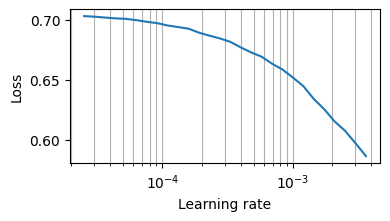

In [ ]:
plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

We can see that the loss reaches a minimum at around `0.003`
.

A good learning rate to choose here would be the middle of the steepest downward curve - which is around `0.003` which is the `Adam` optimizer's default learning rate. This is the learnn rate that is best for our model.

.

In [ ]:
optimizer = torch.optim.Adam(mtscd_model.parameters(), lr=10e-3)
criterion = nn.BCEWithLogitsLoss().to(device)

### Binary Accuracy Function.
In the following code cell we are going to define our `binary_accuracy` function which is a function that caculate the binary accuracy between predicted labels and real labels.

In [ ]:
def binary_accuracy(y_preds, y_true):
  rounded_preds = torch.round(torch.sigmoid(y_preds))
  correct = (rounded_preds == y_true).float()
  return correct.sum() / len(correct)

### Train and Evaluation Function

1. `train`
* first we put the model in the train mode by calling the `model.train()`
*. We will iterate over the iterator and put `labels` and features(`images`) to the `device`
*  we call the `optimizer.zero_grad()` to restore the gradients of the optimizer for each iteration
* we make predictions and calculate the `accuracy` and `loss`
* we then updates the weights by calling `optimizer.step()` after backward propergation using the `loss.backward()`
* we will return the `loss` and the `accuracy`

2. `evaluate`
* we put the model in evaluation mode by calling `model.eval()`
* we wrap our loop with `torch.no_grad()` beacuse we are not interested in calculating the gradients during model evaluation.
* We calculate the `loss` and `accuracy` and return them
Our train and evaluate function are as follows:

In [ ]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.train()
  for (x, y) in iterator:
    # features and labels to the device
    x = x.to(device)
    y = y.to(device).float() # they should be float
    # Zero the gradients
    optimizer.zero_grad()
    y_pred, _ = model(x)

    # Calculate the loss and accuracy
    loss = criterion(y_pred, y.unsqueeze(1))
    acc = binary_accuracy(y_pred.squeeze(), y)
    # Backward propagate
    loss.backward()
    # Update the weights
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

def evaluate(model, iterator, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device).float()  # they should be float
      y_pred, _ = model(x)
      loss = criterion(y_pred, y.unsqueeze(1))
      acc = binary_accuracy(y_pred.squeeze(), y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

### Training loop
We are then going to run our training loop as save the model when the previous validation loss is less that the current validation loss. We are only going to train the model for `50` epochs. We are going to keep in track of the model training history so that we can visualize it later on.

### Early Stoping Techinique

Early Stopping is a regularization technique that improves image classification `accuracy` by intentionally stopping the training when validation loss `increases`. Training is stopped as training a model for too many epochs sometimes causes `Overfitting`. In Early Stopping, the number of epochs becomes a tunable hyperparameter. We continuously store the best parameters during training, and when these parameters no longer change for several epochs, we stop training. The idea of Early Stopping can be seen in this diagram.


![img](https://github.com/CrispenGari/cv-torch/blob/main/05_CANCER_AI_VGG19/images/early-stopping.png?raw=true)


### Early Stopping


In [ ]:
class EarlyStopping(object):
  def __init__(self, tolerance=5, min_delta=0):
    self.tolerance = tolerance
    self.min_delta = min_delta
    self.counter = 0
    self.early_stop = False

  def __call__(self, train_loss, validation_loss):
    if (validation_loss - train_loss) > self.min_delta:
      self.counter +=1
      if self.counter >= self.tolerance:
          self.early_stop = True

Let's create a history container that will store our training history values.

In [ ]:
class History:
  def __init__(self):
    self.train_losses = list()
    self.train_acc = list()
    self.epoch_train_time = list()
    self.val_losses = list()
    self.val_acc = list()

  def add(self, train_loss:float, train_acc:float, val_loss:float, val_acc:float, elt:float):
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_train_time.append(elt)

Now we can run our train loop...


> Note that we can tollerate, the loss for `3` epochs meaning if the validation loss keeps on increasing or is greater than the train loss for `3` consequtive epochs we are going to stop the training imideately to avoid model overfitting.

In [ ]:
EPOCHS = 50
early_stopping = EarlyStopping(tolerance=3, min_delta=10)
N = EPOCHS
best_valid_loss = float('inf')
MODEL_NAME = "mtscd_model.pt"
column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
last_saved_epoch = 1

history = History()
training_start = time.time()

for epoch in range(EPOCHS):
  start = time.time()

  train_loss, train_acc = train(mtscd_model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(mtscd_model, valid_iterator, criterion, device)

  save_status = "(not saving)"
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    save_status = "(saving)"
    last_saved_epoch = epoch + 1
    torch.save(mtscd_model.state_dict(), MODEL_NAME)

  end = time.time()
  history.add(train_loss, train_acc, valid_loss, valid_acc, end-start)


  data_rows = [
      ["Train", f'{train_loss:.3f}', f'{train_acc * 100:.2f}%', hms_string(end-start)],
      ["Validation", f'{valid_loss:.3f}', f'{valid_acc * 100:.2f}%', ""]
  ]

  title = f"EPOCH {epoch+1:02}/{EPOCHS}: {save_status}"
  tabulate_data(column_names, data_rows, title)
  early_stopping(train_loss, valid_loss)
  if early_stopping.early_stop:
    print("Early Stopping Call Back applied!!\n: We are at epoch:", epoch + 1)
    N = epoch+1
    break

training_end = time.time()

EPOCH 01/50: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.406 |   84.04% | 0:01:52.63 |
| Validation | 0.289 |   88.11% |            |
+------------+-------+----------+------------+
EPOCH 02/50: (not saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.416 |   84.85% | 0:01:59.32 |
| Validation | 0.462 |   81.48% |            |
+------------+-------+----------+------------+
EPOCH 03/50: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.403 |   84.92% | 0:01:49.62 |
| Validation | 0.276 |   89.87% |            |
+------------+-------+----------+------------+
EPOCH 04/50: (not saving)
+------------+-------+----------+------------+
| Set      

### Visualizing the training History
In this section of the notebook we are going to visualize the training history of the model over `N` epochs.

In [ ]:
print("----- TOTAL TRAINING TIME ")
rows = [
      ["TOTAL EPOCHS", f'{N}'],
      ["LAST SAVED EPOCH", f'{last_saved_epoch}'],
      ["TOTAL TRAINING TIME", f'{hms_string(training_end-training_start)}']
]
tabulate_data(['', 'value'], rows, "TOTAL TRAINING TIME")

----- TOTAL TRAINING TIME 
TOTAL TRAINING TIME
+---------------------+------------+
|                     |      value |
+---------------------+------------+
| TOTAL EPOCHS        |         50 |
| LAST SAVED EPOCH    |         28 |
| TOTAL TRAINING TIME | 1:27:55.05 |
+---------------------+------------+


Let's plot how long the model took to train each epoch from our `history` object.

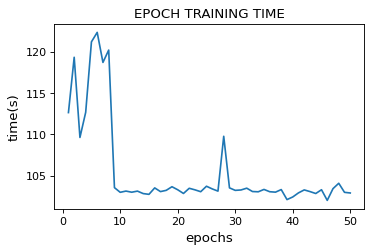

In [ ]:
epochs = np.arange(1, N + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.epoch_train_time)
plt.title("EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)
plt.show()

Let's plot the model's training history in terms of `acuracy` over a period of `N` epochs in our `train` and `valid` sets.

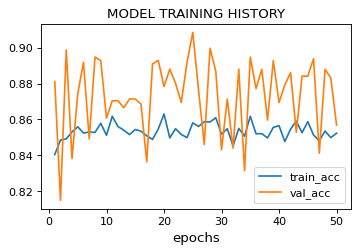

In [ ]:
epochs = np.arange(1, N + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_acc, label="train_acc")
plt.plot(epochs, history.val_acc, label="val_acc")
plt.title("MODEL TRAINING HISTORY", color="k", fontsize=12)
plt.legend()
plt.xlabel("epochs", fontsize=12)
plt.show()

Let's plot the model's training history in terms of `losses` over a period of `N` epochs in our `train` and `valid` sets.

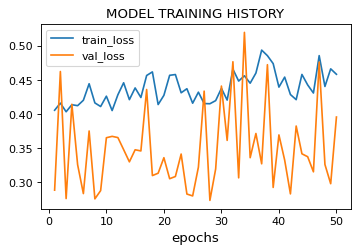

In [ ]:
epochs = np.arange(1, N + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_losses, label="train_loss")
plt.plot(epochs, history.val_losses, label="val_loss")
plt.title("MODEL TRAINING HISTORY", color="k", fontsize=12)
plt.legend()
plt.xlabel("epochs", fontsize=12)
plt.show()

Next we are going to `evaluate` the best model and check for the model `loss` and accuracy based on the `unseen` dataset which is the `test`.

In [ ]:
mtscd_model.load_state_dict(torch.load(MODEL_NAME))

test_loss, test_acc = evaluate(mtscd_model, test_iterator, criterion, device)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', f'{test_acc * 100:.2f}%', ""]]

tabulate_data(column_names, data_rows, title)

Model Evaluation Summary
+------+-------+----------+------------+
| Set  |  Loss | Accuracy | ETA (time) |
+------+-------+----------+------------+
| Test | 0.330 |   88.29% |            |
+------+-------+----------+------------+


We can also visualize and see what metrics the best model achived when we evaluate it using:

1. train
2. validation
3. and test

iterators.

In [ ]:
_test_loss, _test_acc = evaluate(mtscd_model, test_iterator, criterion, device)
_train_loss, _train_acc = evaluate(mtscd_model, train_iterator, criterion, device)
_valid_loss, _valid_acc = evaluate(mtscd_model, valid_iterator, criterion, device)

xs = np.array(['training', 'testing', 'validation'])
losses = np.array([train_loss, _test_loss, _valid_loss])
accuracies = np.array([train_acc * 100, _test_acc * 100, _valid_acc * 100])

Next we are going to visualize the model `accuracies` when it is evaluated using the:

1. train
2. test
3. validation

...data


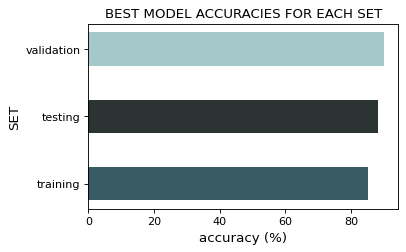

In [ ]:
plt.figure(figsize=(5, 3), dpi=80)
plt.barh(xs, accuracies, label= xs, height=.5, color=['#395B64', '#2C3333', '#A5C9CA'], align="center")
plt.title("BEST MODEL ACCURACIES FOR EACH SET", color="k", fontsize=12)
plt.ylabel("SET", fontsize=12)
plt.xlabel("accuracy (%)", fontsize=12)
# plt.legend(title="SET", fontsize=10)
plt.show()

Next we are going to visualize the model `losses` when it is evaluated using the:

1. train
2. test
3. validation

...data

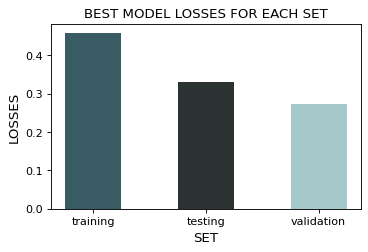

In [ ]:
plt.figure(figsize=(5, 3), dpi=80)
plt.bar(xs, losses, label= xs, width=.5, color=['#395B64', '#2C3333', '#A5C9CA'], align="center")
plt.title("BEST MODEL LOSSES FOR EACH SET", color="k", fontsize=12)
plt.xlabel("SET", fontsize=12)
plt.ylabel("LOSSES", fontsize=12)
# plt.legend(title="SET", fontsize=10)
plt.show()

### Downloading the best model
We are going to download the saved model as a file in the following code cell.

In [ ]:
from google.colab import files
files.download(MODEL_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model Inference
For model inference we are going to take in an image and make predictions on it.

### Image preprocessing
For image preprocessing we are going to use `torchvision` transforms so we are basically going to use the `test_transforms` which looks as follows:

```py
test_transforms = transforms.Compose([
  transforms.Resize(pretrained_size),
  transforms.CenterCrop(pretrained_size),
  transforms.ToTensor(),
  transforms.Normalize(mean = pretrained_means,
                    std = pretrained_stds)
])
```

First we will load the image using Python Image Libray (PIL) and transform it using the `test-transform` wich we defined later on. The `preprocess_img` function defined bellow does exactly that.

In [ ]:
def preprocess_img(img):
  """
  takes in a pillow image and pre process it
  """
  img = image_transforms['test'](img)
  return img

In [ ]:
img_path = os.path.join('melanoma_cancer_dataset', "test/benign/melanoma_10000.jpg")
pil_img = Image.open(img_path)
img = preprocess_img(pil_img)

### Predict method
The predict method will take in the following args:

1. model
2. image (processed image)
3. device (cuda or cpu)

In [ ]:
class Prediction:
    def __init__(self, label:int, probability:float, type_: str) -> None:
        self.label = label
        self.probability = probability
        self.type_ = type_

    def __repr__(self) -> str:
        return f"[{self.type_}]"

    def __str__(self) -> str:
        return f"[{self.type_}]"

    def to_json(self):
        return {
            "label": int(self.label),
            "probability": float(self.probability),
            "type": self.type_,
        }

class Response:
    def __init__(self, top_prediction: Prediction, predictions:list) -> None:
        self.predictions = predictions
        self.top_prediction = top_prediction

    def __repr__(self) -> str:
        return f"[MELANOMA Prediction Response - {self.top_prediction.type_}]"

    def __str__(self) -> str:
        return f"[MELANOMA Prediction Response - {self.top_prediction.type_}]"

    def to_json(self):
        return{
           "predictions": [item.to_json() for item in self.predictions],
            "top_prediction": self.top_prediction.to_json()
        }


In [ ]:
def predict(model, image, device):
  model.eval()
  with torch.no_grad():
    image = image.unsqueeze(dim=0).to(device)
    preds, _ = model(image)
    preds = F.sigmoid(preds).detach().cpu().numpy().squeeze()
    predicted_label =  1 if preds >= 0.5 else 0
    probability = preds if preds > 0.5 else 1 - preds
    predictions = [
        Prediction(
            label = i,
            type_ = c,
            probability = np.round(probability if i == predicted_label else 1 - probability, 2)
        ) for i, c in enumerate(classes)
    ]
    predicted = Prediction(
        label = predicted_label,
        type_ = classes[predicted_label],
        probability = np.round(probability, 2),
    )
    return Response(
        top_prediction = predicted,
        predictions = predictions
    )

### Predicting `benign`

In [ ]:
predict(mtscd_model, img, device).to_json()

{'predictions': [{'label': 0, 'probability': 0.86, 'type': 'benign'},
  {'label': 1, 'probability': 0.14, 'type': 'malignant'}],
 'top_prediction': {'label': 0, 'probability': 0.86, 'type': 'benign'}}

### Predicting `malignant`

In [ ]:
img_path = os.path.join('melanoma_cancer_dataset', "test/malignant/melanoma_10105.jpg")
pil_img = Image.open(img_path)
img = preprocess_img(pil_img)

In [ ]:
predict(mtscd_model, img, device).to_json()

{'predictions': [{'label': 0, 'probability': 0.09, 'type': 'benign'},
  {'label': 1, 'probability': 0.9100000262260437, 'type': 'malignant'}],
 'top_prediction': {'label': 1,
  'probability': 0.9100000262260437,
  'type': 'malignant'}}

### Model Evaluation metrics
In this section we are going to evaluate the best model and visualize the metrics. We are going to use the following evaluation methods on this classification task.

1. `confusion matrix`.
2. `classification report`.
3. `f1_score`
4. `precision`
5. `recall`


First of all we need to get the actual values and predicted values from the `test_iteraror` so that we will be able to use all the examples in the test dataset to evaluate our model. We are going to define a function called `get_predictions` this function will take in the `model`, `iterator` and `device` as parameter and return the following lists of values:

1. `images` - the image to be predicted
2. `labels` - the actual image label
3. `probs` - the list of probabilities for the image to belong to a certain class.




In [124]:
def get_predictions(model, iterator, device):
  model.eval()
  images = []
  labels = []
  probs = []
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y_pred, _ = model(x)
      y_prob = F.sigmoid(y_pred).squeeze().detach()
      images.append(x.cpu())
      labels.append(y.cpu())
      probs.append(y_prob)
  images = torch.cat(images, dim = 0)
  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)
  return images, labels, probs

Let's go ahead and get the `images`, `labels` and `probabilities` from the `test_iterator` using our `get_predictions` function

In [125]:
test_images, test_labels, probs = get_predictions(mtscd_model, test_iterator, device)

The probs are not the predicted labels, it is a torch tensor containing the sigmoid value for each prediction that looks as follows:

```
tensor([0.2493])
```

So this is just a probabilities that is telling us that, the predicted image has `1 - 0.2493` chance to belong to the first class and `0.2493` chance of belonging to the second class. Basically the model is telling us that, I think the image you gave me belongs to class `0`. So for all the values in the probs that are less than `0.5` belongs to class `0` and  to `1` otherwise.

In [126]:
pred_labels = probs.detach().cpu().apply_(lambda x: 1 if x >= 0.5 else 0)
pred_labels[:5]

tensor([0., 0., 0., 0., 0.])

### Ploting predictions
Now that we have our `predicted` labels and `actual` labels from the `test` dataset. We can use them to visualize how good the model is performing during inference. Let's define a function called `plot_predictions_images` which plots the predicted images together with their labels.

In [127]:
images = test_images
labels = test_labels.numpy().astype(np.int32)
preds = pred_labels.numpy().astype(np.int32)

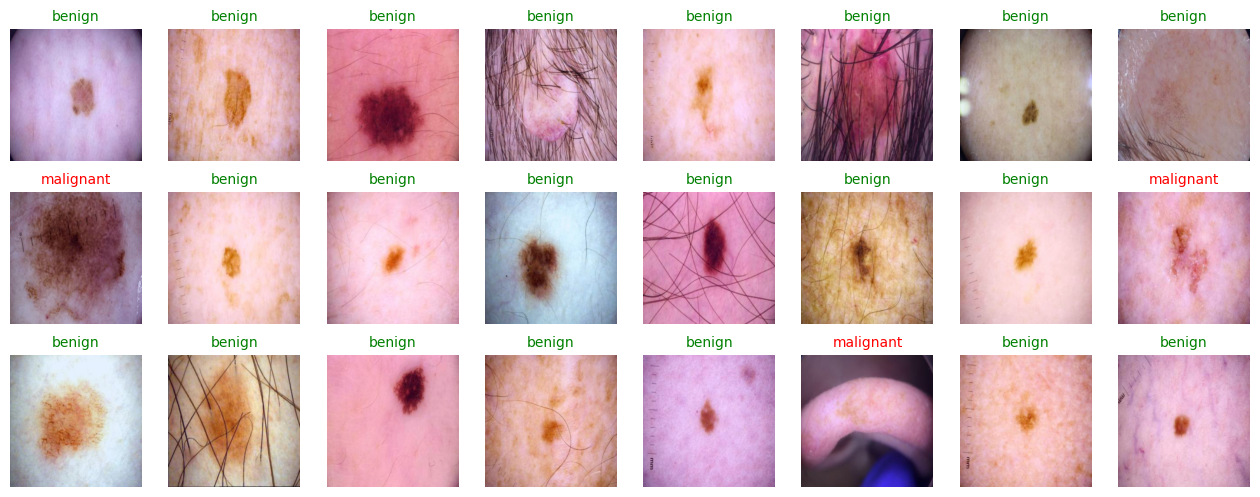

In [128]:
def plot_predictions_images(images_and_classes,
                            labels_true, labels_pred,
                            cols=5):
    rows = 3
    fig = plt.figure()
    fig.set_size_inches(cols * 2, rows * 2)
    for i, (image, label_true, label_pred) in enumerate(zip(images_and_classes, labels_true.astype("int32"), labels_pred)):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        image = normalize_image(image)
        plt.imshow(image.permute(1, 2, 0).cpu().numpy())
        plt.title(class_names[label_pred], color ='g' if label_true == label_pred else 'r', fontsize=10 )

plot_predictions_images(images[:24], labels[:24], preds[:24], cols=8)


From the above visualization the images that has a `red` title are `mis-classified` by the model and the one in `green` was classified well by the model.


### The confusion matrix

Let's create a confusion matrix as a way of visualizing how good our model is when it comes to predicting images in the `test` set. We are going to use a function called `plot_complicated_confusion_matrix` from `helperfns.visualization` in the following code cell, this function will take in the `real-labels`, `predicted labels` together with the classes (textual labels e.g, benign)

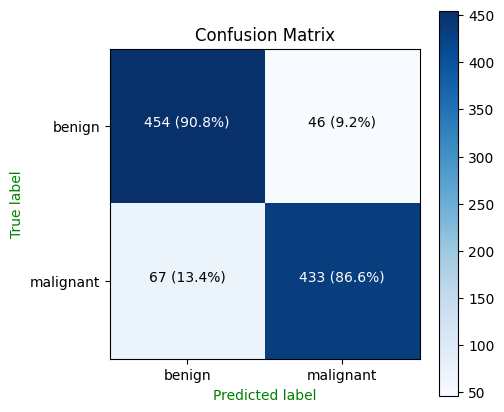

In [129]:
plot_complicated_confusion_matrix(labels, preds, class_names, fontsize=10, figsize=(5, 5))

### Classification report

In the following code cell we are going to print the classification report as a way of measuring how good our model was in predicting (benign and malignant) melenoma skin cancers.

In [130]:
cr = classification_report(labels, preds, output_dict=False)
print(cr)

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       500
           1       0.90      0.87      0.88       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



In [131]:
def plot_classification_report(y_test, y_pred, title='Classification Report', figsize=(8, 6), dpi=70, save_fig_path=None, **kwargs):
    """
    Plot the classification report of sklearn

    Parameters
    ----------
    y_test : pandas.Series of shape (n_samples,)
        Targets.
    y_pred : pandas.Series of shape (n_samples,)
        Predictions.
    title : str, default = 'Classification Report'
        Plot title.
    fig_size : tuple, default = (8, 6)
        Size (inches) of the plot.
    dpi : int, default = 70
        Image DPI.
    save_fig_path : str, defaut=None
        Full path where to save the plot. Will generate the folders if they don't exist already.
    **kwargs : attributes of classification_report class of sklearn

    Returns
    -------
        fig : Matplotlib.pyplot.Figure
            Figure from matplotlib
        ax : Matplotlib.pyplot.Axe
            Axe object from matplotlib
    """
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    clf_report = classification_report(y_test, y_pred, output_dict=True, **kwargs)
    keys_to_plot = [key for key in clf_report.keys() if key not in ('accuracy', 'macro avg', 'weighted avg')]
    df = pd.DataFrame(clf_report, columns=keys_to_plot).T
    #the following line ensures that dataframe are sorted from the majority classes to the minority classes
    df.sort_values(by=['support'], inplace=True)

    #first, let's plot the heatmap by masking the 'support' column
    rows, cols = df.shape
    mask = np.zeros(df.shape)
    mask[:,cols-1] = True
    ax = sns.heatmap(df, mask=mask, annot=True, cmap="Blues", fmt='.3g',
            vmin=0.0,
            vmax=1.0,
            linewidths=2, linecolor='white'
     )

    #then, let's add the support column by normalizing the colors in this column
    mask = np.zeros(df.shape)
    mask[:,:cols-1] = True

    ax = sns.heatmap(df, mask=mask, annot=True, cbar=False,
            linewidths=2, linecolor='white', fmt='.0f',
            vmin=df['support'].min(),
            vmax=df['support'].sum(),
            norm=mpl.colors.Normalize(vmin=df['support'].min(),
                                      vmax=df['support'].sum())
                    )

    plt.title(title)
    plt.xticks(rotation = 45)
    plt.yticks(rotation = 360)

    if (save_fig_path != None):
        path = pathlib.Path(save_fig_path)
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_fig_path)
    return fig, ax

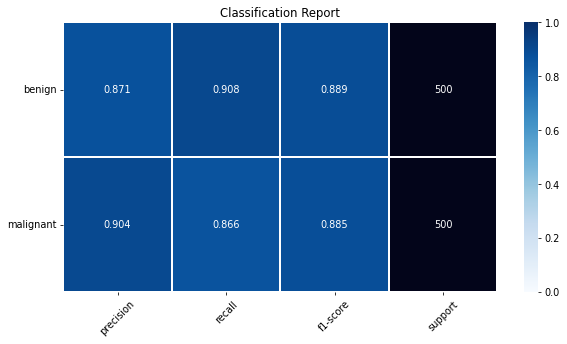

In [132]:
fig, ax = plot_classification_report(labels, preds,
                    title='Classification Report',
                    figsize=(10, 5), dpi=70,
                    target_names= classes)

### F1 Score
`F1 score` is a machine learning evaluation metric that measures a model's accuracy. It combines the `precision` and `recall` scores of a model. The accuracy metric computes how many times a model made a correct prediction across the entire dataset.


In the following code cell we are going to calculate the `f1_score` of the model in the test dataset.

In [133]:
score = f1_score(labels, preds, labels=np.array([0, 1], dtype=np.float32))
score

0.8845760980592442

### Precision Score

`Precision` score measures the proportion of positively predicted labels that are actually correct. Precision is also known as the positive predictive value.


Let's check the precision score of our classifier based on our examples on the test set.

In [134]:
precision = precision_score(labels, preds, labels=np.array([0, 1], dtype=np.float32))
precision

0.9039665970772442

### Recall Score

Recall score is used to measure the model performance in terms of measuring the count of true positives in a correct manner out of all the actual positive values.

In [135]:
recall = recall_score(labels, preds, labels=np.array([0, 1], dtype=np.float32))
recall

0.866

### Incorrect predictions

We can get all the correct predictions and filter out all the incorrect predictions sort them out based on how confident they were on their incorrect prediction.

In [136]:
corrects = torch.eq(torch.from_numpy(labels), torch.from_numpy(preds))

Getting incorrect predicted examples...

In [137]:
probabilities = [prob if prob > .5 else 1 - prob for prob in probs]

In [138]:
incorrect_examples = []
for image, label, prob, correct in zip(images, labels, probabilities, corrects):
  if not correct:
    incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

We can then plot the most incorrectly predicted images along with the predicted class and the actual class.

In [139]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize = (25, 20))
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image, true_label, probs = incorrect[i]
    image = image.permute(1, 2, 0)
    true_class = classes[true_label]
    incorrect_class = classes[0 if true_label == 1 else 1]
    if normalize:
      image = normalize_image(image)
    ax.imshow(image.cpu().numpy())
    ax.set_title(f'real: {true_class}\n' \
                  f'predicted: {incorrect_class}')
    ax.axis('off')
  fig.subplots_adjust(hspace=0.4)

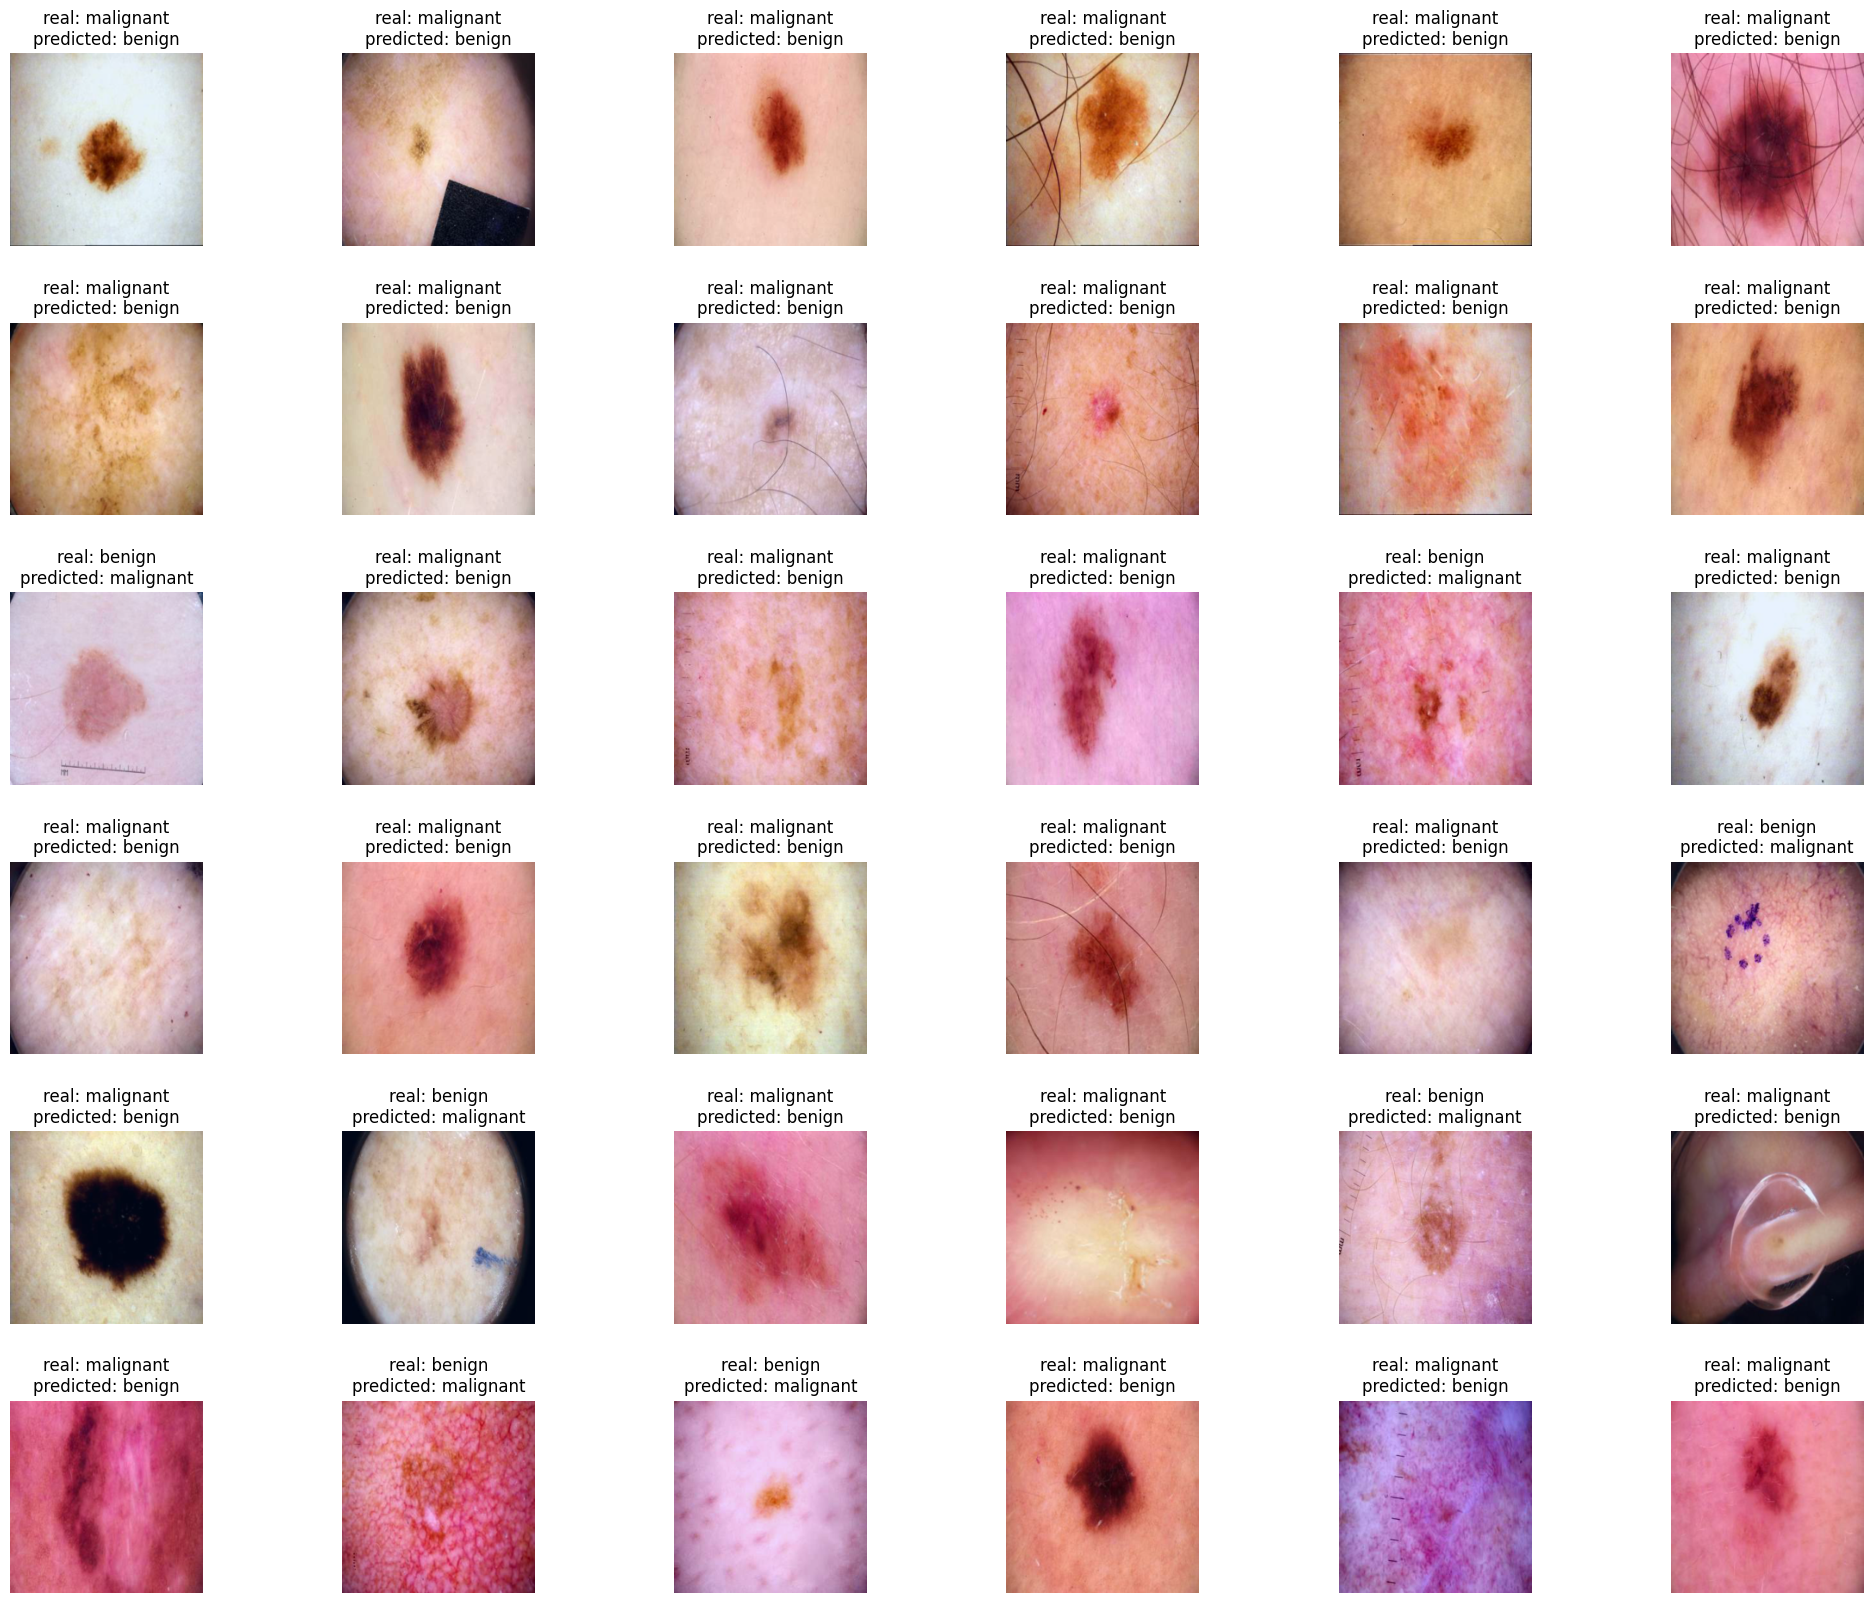

In [140]:
N_IMAGES = 36
plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

Another thing we can do is get the output and intermediate representations from the model and try to visualize them.

The function below loops through the provided dataset and gets the output from the model and the intermediate representation from the layer before that, the second hidden layer.

#### Refs

The following links references to resources that was used in this notebook:


1. [www.kaggle.com/datasets](https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images)
2. [03_Torch_Vision/03_Image_Classification/04_VGG](https://github.com/CrispenGari/pytorch-python/blob/main/03_Torch_Vision/03_Image_Classification/04_VGG.ipynb)
3. [03_Torch_Vision/03_Image_Classification/05_ResNet](https://github.com/CrispenGari/pytorch-python/blob/main/03_Torch_Vision/03_Image_Classification/05_ResNet.ipynb)
4. [github/bentrevett](https://nbviewer.org/github/bentrevett/pytorch-image-classification/blob/master/5_resnet.ipynb)